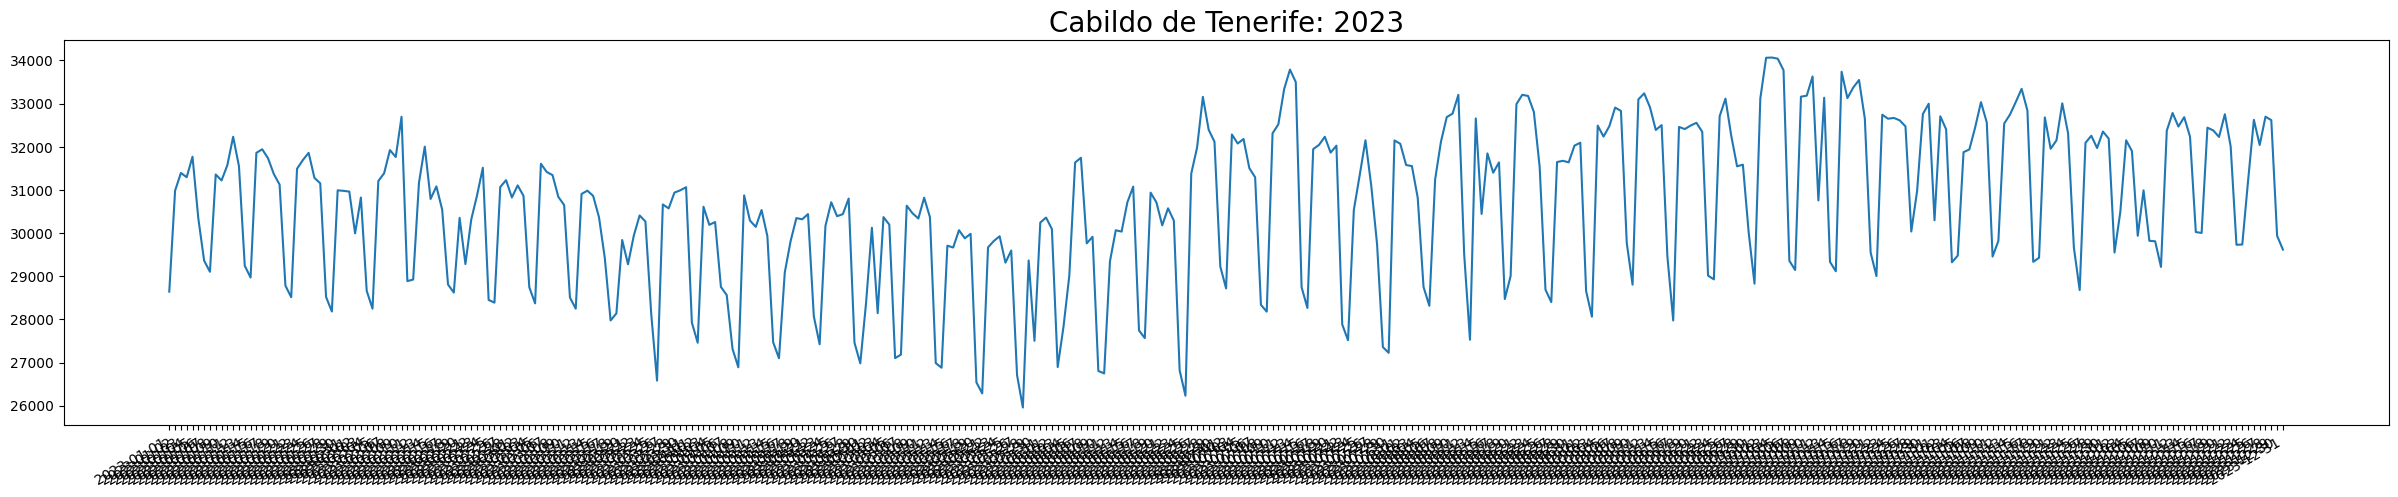

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/consumo-energetico-2023.csv') # 2023 empieza en enero y termina en diciembre

def daily(df):
    grouped = df.groupby('fecha')['consumo'].sum().reset_index()
    
    if len(grouped) > 1 and grouped.iloc[-1, 1] < 0.5 * grouped.iloc[-2, 1]:
        grouped = grouped.iloc[:-1]  # Remove last two entries if the last value is too low

    return grouped.rename(columns={'fecha': 'date', 'consumo': 'value'})

timeseries = daily(df)

plt.figure(figsize=(30,5))
plt.title(f"Cabildo de Tenerife: {timeseries['date'].values[0][:4]}", size = 20)
plt.plot(timeseries['date'].values, timeseries['value'].values)
plt.xticks(rotation=30, ha='right')
plt.show()

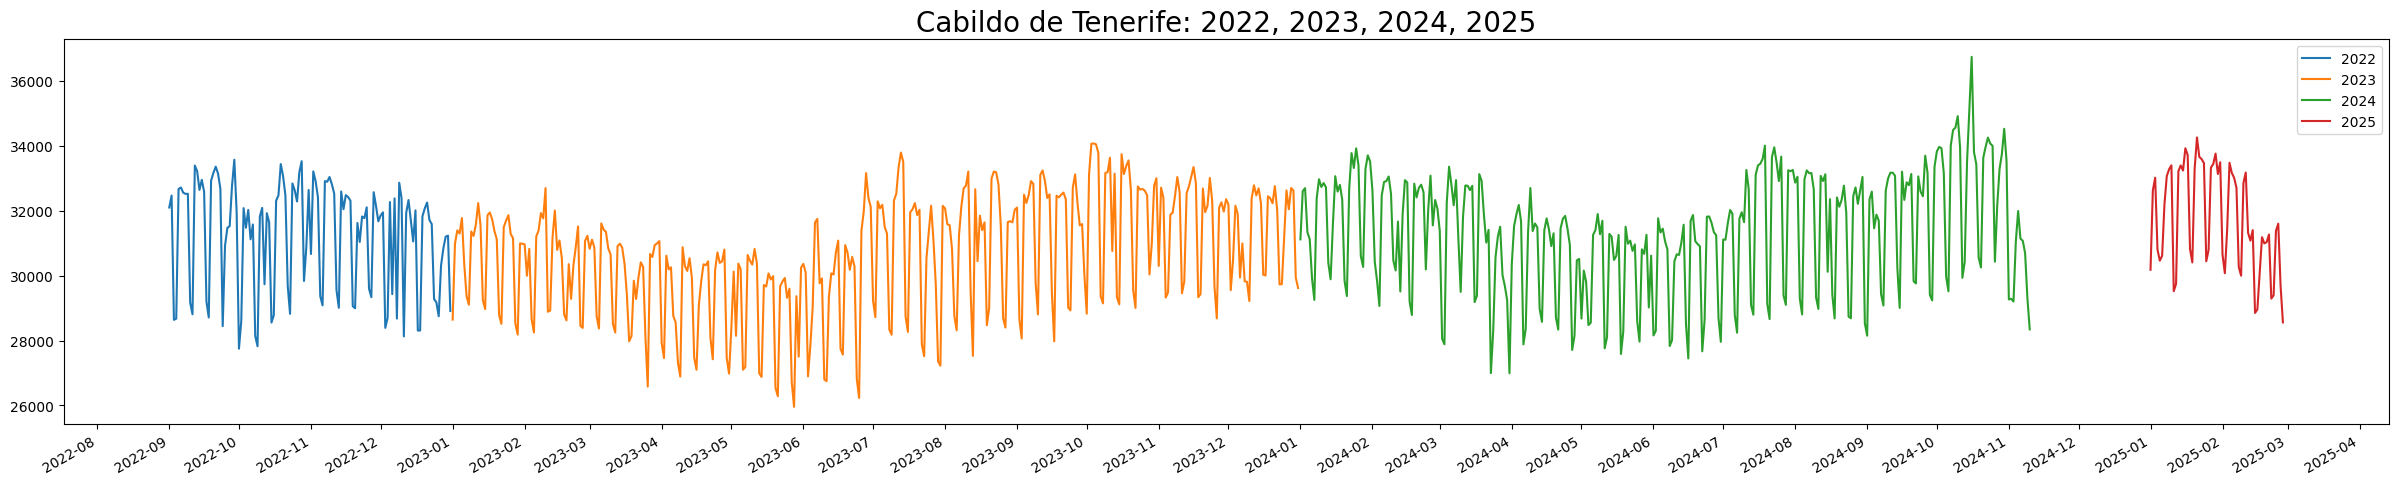

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def daily(df):
    grouped = df.groupby('fecha')['consumo'].sum().reset_index()
    if len(grouped) > 1 and grouped.iloc[-1, 1] < 0.5 * grouped.iloc[-2, 1]:
        grouped = grouped.iloc[:-1]  # Remove last entry if it's incomplete
    grouped = grouped.rename(columns={'fecha': 'date', 'consumo': 'value'})
    # Convert the date column to datetime
    grouped['date'] = pd.to_datetime(grouped['date'])
    return grouped

years = [2022, 2023, 2024, 2025]

plt.figure(figsize=(30, 5))
for year in years:
    df = pd.read_csv(f'../data/consumo-energetico-{year}.csv')
    timeseries = daily(df)
    plt.plot(timeseries['date'], timeseries['value'], label=str(year))

plt.title('Cabildo de Tenerife: ' + ', '.join(map(str, years)), size=20)
plt.xticks(rotation=30, ha='right')
plt.legend()

ax = plt.gca()
# Set x-axis ticks to every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()


# Entrenamiento de septiembre 2022 a octubre 2024 y testeo noviembre 2024

In [3]:
years = [2022, 2023, 2024]

total = pd.DataFrame()
for year in years:
    df = pd.read_csv(f'../data/consumo-energetico-{year}.csv')
    timeseries = daily(df)
    total = pd.concat([total, timeseries])

In [4]:
sept22_oct23 = total[:int(len(total['date'].values)-41)]

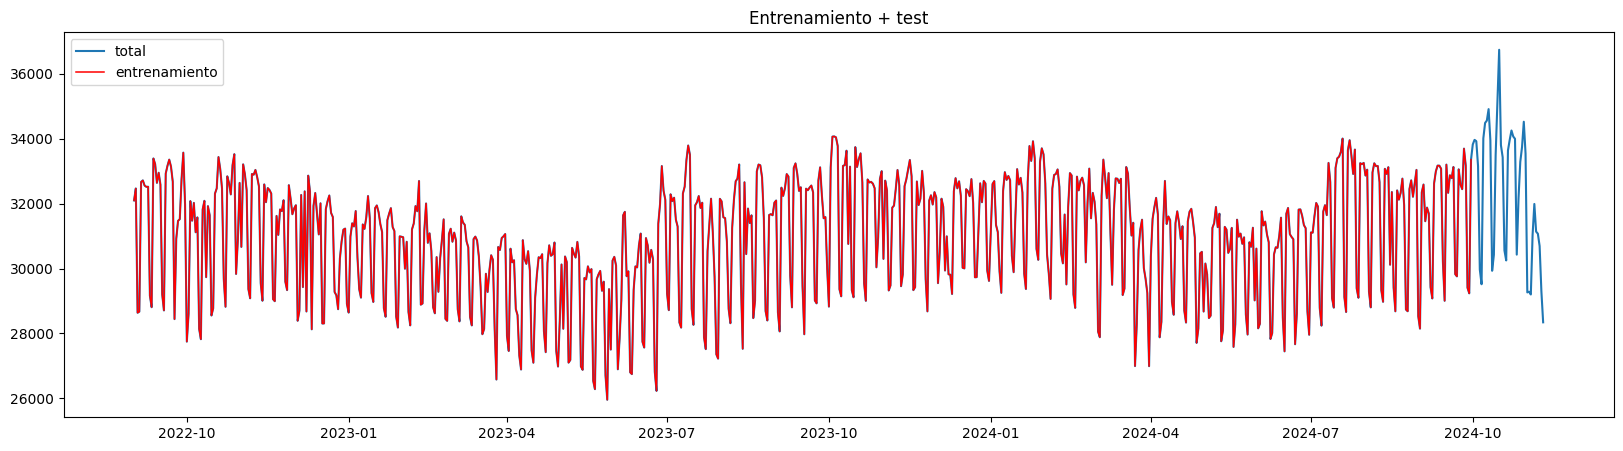

In [5]:
plt.figure(figsize=(20,5))
plt.title('Entrenamiento + test')
plt.plot(total['date'].values, total['value'].values, label = 'total')
plt.plot(sept22_oct23['date'].values, sept22_oct23['value'].values, label = 'entrenamiento', color = 'r', linewidth = 1.1)
plt.legend()
plt.show()

# Classic comparison

In [6]:
total = total.set_index('date')

/home/nikitakhvatkin/anaconda3/envs/timeseries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nikitakhvatkin/anaconda3/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/nikitakhvatkin/anaconda3/envs/timeseries/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/nikitakhvatkin/anaconda3/envs/timeseries/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/nikitakhvatkin/anaconda3/envs/timeseries/lib

                   Model          MAE         RMSE      MAPE
0  Exponential Smoothing  1086.860324  1456.616083  3.375499
1              AutoARIMA  1583.930180  1966.053491  4.874962
2                  Theta  1146.451013  1415.258590  3.517466
3                    FFT  1611.816274  1938.329919  4.911756


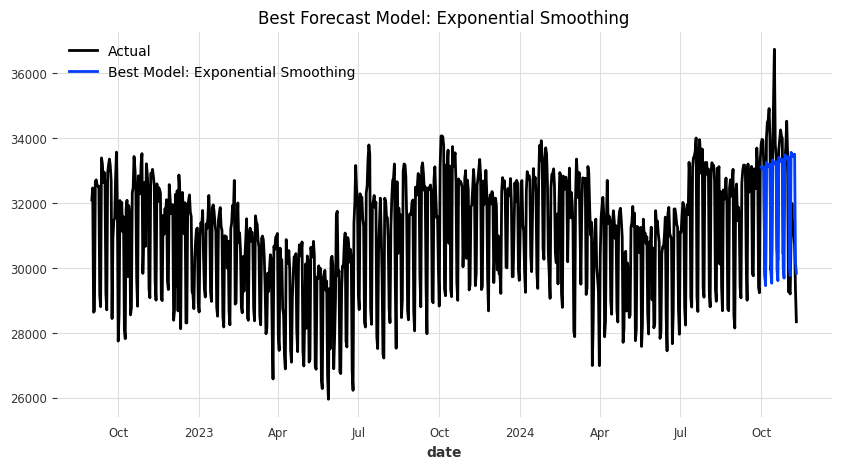

In [7]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import ExponentialSmoothing, AutoARIMA, Theta, FFT
from darts.metrics import mae, rmse, mape
import matplotlib.pyplot as plt

total['value'] = total['value'].astype(np.float32)

# Create time series object
series = TimeSeries.from_dataframe(total, value_cols='value')
train, val = series.split_after(pd.Timestamp('2024-09-30'))

# Define models
models = {
    "Exponential Smoothing": ExponentialSmoothing(),
    "AutoARIMA": AutoARIMA(),
    "Theta": Theta(),
    "FFT": FFT()
}

# Store results
results = []
best_model = None
best_mape = float("inf")
best_forecast = None
best_model_name = ""

for name, model in models.items():
    model.fit(train)
    forecast = model.predict(len(val))
    
    error_mae = mae(val, forecast)
    error_rmse = rmse(val, forecast)
    error_mape = mape(val, forecast)
    
    results.append([name, error_mae, error_rmse, error_mape])
    
    # Track the best model based on MAPE
    if error_mape < best_mape:
        best_mape = error_mape
        best_model = model
        best_forecast = forecast
        best_model_name = name

# Create results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE"])

# Print results
print(results_df)

# Plot the best model's forecast
plt.figure(figsize=(10, 5))
series.plot(label="Actual")
best_forecast.plot(label=f"Best Model: {best_model_name}")
plt.title(f"Best Forecast Model: {best_model_name}")
plt.legend()
plt.show()

# NBEATSModel

In [8]:
# from darts import TimeSeries
# from darts.models import NBEATSModel
# from darts.metrics import mae, rmse, mape

# import torch

# total['value'] = total['value'].astype(np.float32)

# series = TimeSeries.from_dataframe(total, value_cols='value') # creates timeseries
# series.astype(np.float32)

# train, val = series.split_after(pd.Timestamp('2024-09-30')) # splits into training and test

# NBEAT = NBEATSModel(
#     input_chunk_length = 30,
#     output_chunk_length = 30,
#     n_epochs = 100,
#     random_state = 42,
#     # verbose = True
# )
# NBEAT.fit(train, verbose = True)

# forecast = NBEAT.predict(40)

# error_mae = mae(val, forecast)
# error_rmse = rmse(val, forecast)
# error_mape = mape(val, forecast)

# print(f"Mean Absolute Error (MAE): {error_mae:.2f}")
# print(f"Root Mean Squared Error (RMSE): {error_rmse:.2f}")
# print(f"Mean Absolute Percentage Error (MAPE): {error_mape:.2f}%")

# plt.figure(figsize=(20, 5))
# plt.title('NBEATS')
# series.plot(label = 'Historical', lw = 2)
# forecast.plot(label = 'Forecast', lw = 2)
# plt.legend()
# plt.show()

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 M  | train
6 | V               | Linear           | 385    | train
-------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.110     Total estimated model params size (MB)
7 

Training RNNModelLSTM...
Epoch 49: 100%|██████████| 24/24 [00:01<00:00, 21.66it/s, train_loss=9.06e+8]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 24/24 [00:01<00:00, 21.63it/s, train_loss=9.06e+8]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]
Training RNNModelGRU...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 3.1 M  | train
6 | V               | Linear           | 385    | train
-------------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.429    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 24/24 [00:03<00:00,  7.64it/s, train_loss=9.41e+8]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 24/24 [00:03<00:00,  7.64it/s, train_loss=9.41e+8]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]
Training BlockRNNModelLSTM...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 M  | train
6 | fc              | Sequential       | 4.6 K  | train
-------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.127     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 23/23 [00:01<00:00, 19.67it/s, train_loss=9.3e+8] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 23/23 [00:01<00:00, 19.65it/s, train_loss=9.3e+8]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.40it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 3.1 M  | train
6 | fc              | Sequential       | 4.6 K  | train
-------------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.446    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode



Training BlockRNNModelGRU...
Epoch 49: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s, train_loss=9.23e+8]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s, train_loss=9.23e+8]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.16it/s]
Training NBEATSModel...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 3.4 M  | train
-------------------------------------------------------------
3.4 M     Trainable params
789       Non-trainable params
3.4 M     Total params
13.583    Total estimated model params size (MB)
966       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 23/23 [00:02<00:00,  7.91it/s, train_loss=6.53e+5]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 23/23 [00:02<00:00,  7.91it/s, train_loss=6.53e+5]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 2.5 M  | train
-------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.102    Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode



Training TCNModel...
Epoch 49: 100%|██████████| 23/23 [00:03<00:00,  6.27it/s, train_loss=2.08e+6]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 23/23 [00:03<00:00,  6.26it/s, train_loss=2.08e+6]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]
               Model           MAE          RMSE       MAPE
0       RNNModelLSTM  31935.585938  32004.126953  98.522255
1        RNNModelGRU  31940.205078  32008.734375  98.536568
2  BlockRNNModelLSTM  31965.892578  32034.365234  98.616173
3   BlockRNNModelGRU  31967.164062  32035.632812  98.620132
4        NBEATSModel   1122.191895   1507.862915   3.461818
5           TCNModel   3372.293945   3626.010254  10.288775


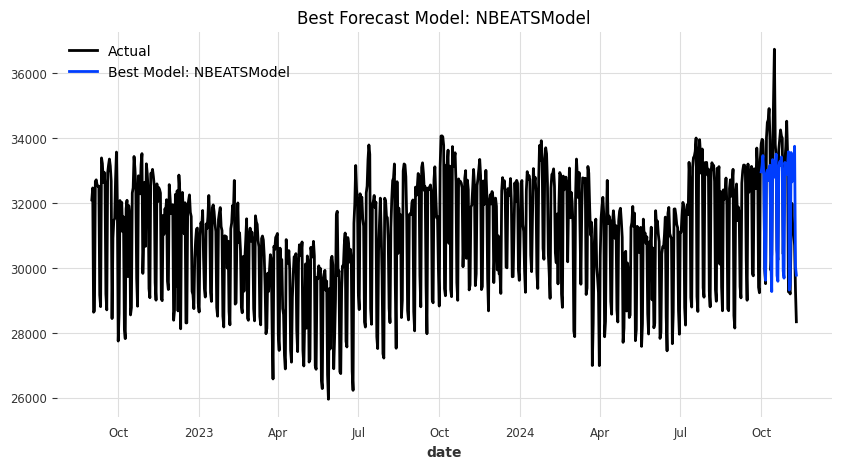

In [9]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import RNNModel, BlockRNNModel, NBEATSModel, TCNModel
from darts.metrics import mae, rmse, mape
import matplotlib.pyplot as plt

# Ensure 'total' DataFrame exists and 'value' column is float
# total = pd.read_csv('your_data.csv')  # Uncomment and modify as needed
total['value'] = total['value'].astype(np.float32)

# Create time series object
series = TimeSeries.from_dataframe(total, value_cols='value')
train, val = series.split_after(pd.Timestamp('2024-09-30'))

# Define deep learning models with tuned hyperparameters for roughly ~2M trainable parameters

models = {
    # RNNModel using LSTM cells with 2 layers and a hidden dimension of 384.
    "RNNModelLSTM": RNNModel(
        model='LSTM',
        input_chunk_length=24,
        output_chunk_length=12,
        hidden_dim=384,
        n_rnn_layers=2,
        random_state=42
    ),
    # RNNModel using GRU cells with 2 layers and a hidden dimension of 384.
        "RNNModelGRU": RNNModel(
        model='GRU',
        input_chunk_length=24,
        output_chunk_length=12,
        hidden_dim=384,
        n_rnn_layers=4,
        random_state=42
    ),
    # BlockRNNModel with LSTM with similar configuration.
    "BlockRNNModelLSTM": BlockRNNModel(
        model = 'LSTM',
        input_chunk_length=24,
        output_chunk_length=12,
        hidden_dim=384,
        n_rnn_layers=2,
        random_state=42
    ),
    # BlockRNNModel with GRUwith similar configuration.
    "BlockRNNModelGRU": BlockRNNModel(
        model = 'GRU',
        input_chunk_length=24,
        output_chunk_length=12,
        hidden_dim=384,
        n_rnn_layers=4,
        random_state=42
    ),
    # NBEATSModel using 3 blocks, each with 3 layers and a width of 256.
    "NBEATSModel": NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        num_blocks=3,
        num_layers=3,
        layer_widths=128,  # This parameter sets the width of the fully-connected layers.
        random_state=42
    ),
    # TCNModel with 10 layers and 256 filters per layer. # TODO see why it crashes
    "TCNModel": TCNModel(
        input_chunk_length=24,
        output_chunk_length=12,
        kernel_size=3,
        num_filters=216,
        num_layers=10,
        random_state=42
    ),
}

# Store results and track the best model based on MAPE
results = []
best_model = None
best_mape = float("inf")
best_forecast = None
best_model_name = ""

for name, model in models.items():
    print(f"Training {name}...")
    # Train for 50 epochs; adjust epochs as needed
    model.fit(train, epochs=50, verbose=True)
    forecast = model.predict(len(val))
    
    error_mae = mae(val, forecast)
    error_rmse = rmse(val, forecast)
    error_mape = mape(val, forecast)
    
    results.append([name, error_mae, error_rmse, error_mape])
    
    # Track the best model based on MAPE
    if error_mape < best_mape:
        best_mape = error_mape
        best_model = model
        best_forecast = forecast
        best_model_name = name

# Create results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE"])

# Print results
print(results_df)

# Plot the best model's forecast
plt.figure(figsize=(10, 5))
series.plot(label="Actual")
best_forecast.plot(label=f"Best Model: {best_model_name}")
plt.title(f"Best Forecast Model: {best_model_name}")
plt.legend()
plt.show()
